In [1]:
# Generate joke by sampling trained LSTM CVAE

from __future__ import print_function
import os
import cPickle as pickle
import json

import numpy as np
import tensorflow as tf

from keras import backend as K
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences

from data_generator import DataGenerator
from lstm_cvae_model import ModelConfig

np.random.seed(123)

Using TensorFlow backend.


In [4]:
# Load trained models

MODEL_DIR = "/Users/tongwang/Playground/deepjoke/code/model_checkpoints/lstm_cvae/20170615_070428"
encoder_path = MODEL_DIR + "/encoder_checkpoint"
generator_path = MODEL_DIR + "/generator_checkpoint"
tokenizer_path = MODEL_DIR + "/tokenizer.p"
model_config_path = MODEL_DIR + "/model_config.json"

encoder = load_model(encoder_path)
generator = load_model(generator_path)
tokenizer = pickle.load(open(tokenizer_path, "r"))
model_config = json.load(open(model_config_path, "r"))

//anaconda/lib/python2.7/site-packages/keras/models.py:248: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [38]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def sample(preds, temperature=1.0):
    """Helper function to sample an index from a probability array"""
    preds = np.asarray(preds).astype('float64')
    preds = softmax(preds)  # Convert logits into probabilities
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def tokens_to_words(tokens, tokenizer, eos=""):
    """Helper function to turn an 1-d array of tokens tokenized by tokenizer back to words"""
    reverse_word_index = {index: word for word, index in tokenizer.word_index.iteritems()}
    reverse_word_index[0] = eos
    words = [reverse_word_index.get(token) for token in tokens]
    text = " ".join(words)
    return text

In [39]:
def generate(target_score, generator, model_config, tokenizer, temperature=None, eos=""):
    """Function to generate paragraphs given a (randomly generated) latent state
    
    Args:
        -generator
        -model_config: a dict holding model configs
        -tokenizer
        -temperature: if None, generate text greedily; otherwise sample stochastically
    Returns:
        -model_config.batch_size many pieces of text
    """
    # Make predictions
    z = np.random.normal(size=(model_config["batch_size"], model_config["latent_size"]))
    scores = np.repeat(target_score, model_config["batch_size"])
    preds = generator.predict([z, scores])
    if temperature is None:
        preds = np.argmax(preds, axis=2)
    else:
        preds = np.apply_along_axis(lambda x: sample(x, temperature=temperature), 2, preds)
        
    # Translate tokens to words
    texts = np.apply_along_axis(lambda x: tokens_to_words(x, tokenizer, eos=eos), 1, preds)
    
    return texts

In [7]:
# Test
texts = generate(target_score=5,
                generator=generator,
                model_config=model_config,
                tokenizer=tokenizer,
                temperature=0.5)
texts

In [46]:
def generate_from_input(input_text, target_score, 
                        encoder, generator, 
                        model_config, tokenizer, temperature=None, eos=""):
    """Function to generate text based on input text"""
    # Tokenizer input text
    input_text = [input_text]
    input_tokens = tokenizer.texts_to_sequences(input_text)
    input_tokens = pad_sequences(input_tokens, maxlen=model_config["max_sequence_length"],
                                 padding='post', truncating='post')
    input_tokens = np.repeat(input_tokens, model_config["batch_size"], axis=0)
    scores = np.repeat(target_score, model_config["batch_size"])
    
    # Encode
    z = encoder.predict([input_tokens, scores])
    
    # Decode
    preds = generator.predict([z, scores])
    if temperature is None:
        preds = np.argmax(preds, axis=2)
    else:
        preds = np.apply_along_axis(lambda x: sample(x, temperature=temperature), 2, preds)
        
    # Translate tokens to words
    texts = np.apply_along_axis(lambda x: tokens_to_words(x, tokenizer, eos=eos), 1, preds)
    
    return texts[0], z[0]

In [47]:
# Test
text, z = generate_from_input(input_text="a man walks into a bar with a sexy lady haha", target_score="5",
                            encoder=encoder,
                            generator=generator,
                            model_config=model_config,
                            tokenizer=tokenizer,
                            temperature=None)

In [90]:
def encode(input_texts, input_scores, encoder, model_config, tokenizer):
    """Function to encode input texts"""
    # Tokenizer input text
    input_tokens = tokenizer.texts_to_sequences(input_texts)
    input_tokens = pad_sequences(input_tokens, maxlen=model_config["max_sequence_length"],
                                 padding='post', truncating='post')
    input_scores = np.array(input_scores)
    # Encode
    z = encoder.predict([input_tokens, input_scores])
    return z

# Analysis

## Encoded vector distribution

In [111]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [14]:
model_config["max_nb_examples"]

In [31]:
# Get text data
data_generator = DataGenerator(
        input_path="/Users/tongwang/Playground/deepjoke/joke-dataset/reddit_jokes.json",
        min_score=model_config["min_score"], 
        max_nb_words=model_config["max_nb_words"],
        max_nb_examples=None,
        max_sequence_length=model_config["max_sequence_length"],
        validation_split=model_config["validation_split"])

In [85]:
texts, scores = data_generator.read_and_clean()

Read in 194553 jokes.
Read in 194553 scores.



In [108]:
some_texts = texts[0: 16384]
some_scores = scores[0: 16384]

In [109]:
zs = encode(some_texts, some_scores, encoder=encoder, model_config=model_config, tokenizer=tokenizer)

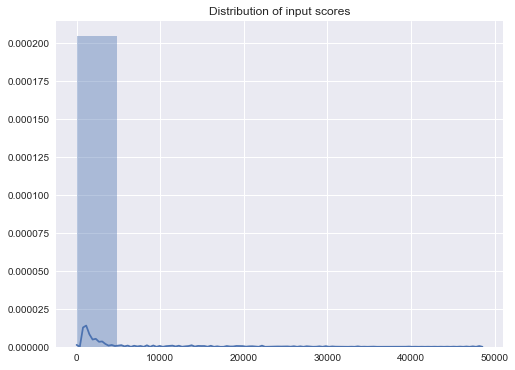

In [114]:
# Plot of scores distribution
fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(some_scores, bins=10, ax=ax, norm_hist=True)
ax.set_title("Distribution of input scores")
fig.show()

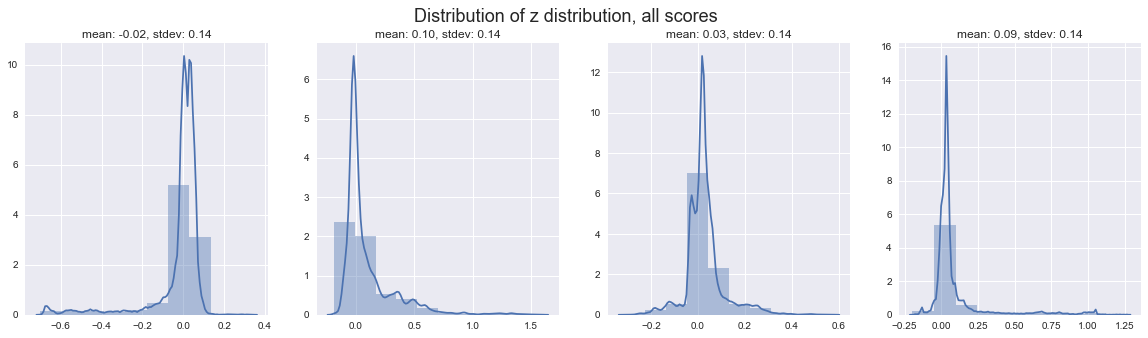

In [123]:
# Plot of z for all score - 4 random dims
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
z1 = zs[:, 1]
z2 = zs[:, 2]
z3 = zs[:, 3]
z4 = zs[:, 4]
sns.distplot(z1, bins=10, ax=ax1, norm_hist=True)
sns.distplot(z2, bins=10, ax=ax2, norm_hist=True)
sns.distplot(z3, bins=10, ax=ax3, norm_hist=True)
sns.distplot(z4, bins=10, ax=ax4, norm_hist=True)
ax1.set_title("mean: {:.2f}, stdev: {:.2f}".format(z1.mean(), z1.std()))
ax2.set_title("mean: {:.2f}, stdev: {:.2f}".format(z2.mean(), z1.std()))
ax3.set_title("mean: {:.2f}, stdev: {:.2f}".format(z3.mean(), z1.std()))
ax4.set_title("mean: {:.2f}, stdev: {:.2f}".format(z4.mean(), z1.std()))
fig.suptitle("Distribution of z distribution, all scores", fontsize=18)
fig.show()

__Remark: these are pretty far from normal distributions, especially the stdev being too small__

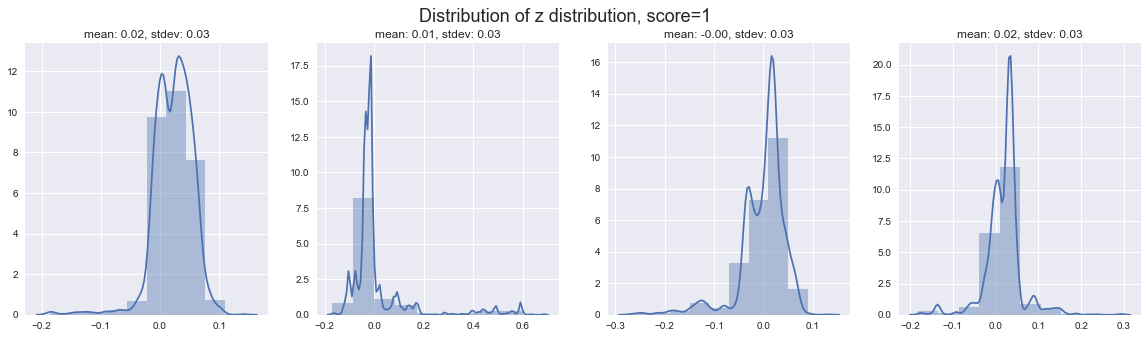

In [126]:
idx = (np.array(some_scores) == 1)

# Plot of z for some particular score
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
z1 = zs[idx, 1]
z2 = zs[idx, 2]
z3 = zs[idx, 3]
z4 = zs[idx, 4]
sns.distplot(z1, bins=10, ax=ax1, norm_hist=True)
sns.distplot(z2, bins=10, ax=ax2, norm_hist=True)
sns.distplot(z3, bins=10, ax=ax3, norm_hist=True)
sns.distplot(z4, bins=10, ax=ax4, norm_hist=True)
ax1.set_title("mean: {:.2f}, stdev: {:.2f}".format(z1.mean(), z1.std()))
ax2.set_title("mean: {:.2f}, stdev: {:.2f}".format(z2.mean(), z1.std()))
ax3.set_title("mean: {:.2f}, stdev: {:.2f}".format(z3.mean(), z1.std()))
ax4.set_title("mean: {:.2f}, stdev: {:.2f}".format(z4.mean(), z1.std()))
fig.suptitle("Distribution of z distribution, score=1", fontsize=18)
fig.show()

__Remark: the same; stdev seems to be really small. Why is this so?__

I think I know why: in the previous training run the loss term from lstm is expressed as a sum...therefore dorminates the kl term. Simply setting the loss terms to mean might alleviate this.